In [1]:
import numpy as np
from matplotlib import pylab as plt
import scipy as sp
from os import listdir,path
from os.path import isfile,join,isdir
from scipy.optimize import curve_fit
from scipy.stats import norm
import math
from scipy import asarray as ar,exp
import pandas as pd

def gaus(x,a,x0,sigma):
  return (a/sigma)*exp(-(x-x0)**2/(2*sigma**2))

def midpoints(hvals):
    hvals_shift=np.append(hvals[1:],0)
#     print(hvals)
#     print(hvals[1:])
#     print(np.append(hvals[1:],0))
    midp=(hvals+hvals_shift)/2.0
    return midp[:-1]

def get_files(directory_path):
    dirpath=directory_path

    files=[f for f in listdir(dirpath) if isfile(join(dirpath, f))]
    files=sorted(files)
    n_files=len(files)
    print ("number of files="+str(n_files))
    return files,n_files

def chosePix(startx_fn,endx_fn,starty_fn,endy_fn,dirpath_fn,files_fn,n_files_fn):
    
    chosenPix=np.array([])
    chosenPixels=np.array([])
    imarray=np.zeros([2800,2400],dtype='float')
    imarraySq=np.zeros([2800,2400],dtype='float')
    for j,file_iter in enumerate(files_fn):
        if(j%10==0):
            print(j,file_iter)

        if ".tiff" not in file_iter: 
            continue
        else:
            im=plt.imread(str(dirpath_fn+"/"+file_iter)) #np.fromfile(file_iter,dtype='uint16',sep="")
            im=im.astype('float')
            imarray=imarray+(im/n_files_fn)
            imarraySq=imarraySq+(np.square(im)/n_files_fn)
            chosenPix=np.append(chosenPix,im[starty_fn,startx_fn])
            chosenPixels=np.append(chosenPixels,im[starty_fn:endy_fn,startx_fn:endx_fn])

    std=(imarraySq-np.square(imarray))
    std[std<0]=0
    std=np.sqrt(std)

    return chosenPix, chosenPixels, std

def return_param_BPM(even_odd,hist_val,num):
    if even_odd=="odd":
        eo=1
    else:
        eo=0
    print(even_odd,hist_val)
    histValues=ax[eo,num].hist(df[(df['y_vals']%2==eo)&(df['heights']<1000)][hist_val],bins=45)
    mphist=midpoints(histValues[1])
    meanh=df[(df['y_vals']%2==eo)&(df['heights']<1000)&(df['means']>0)][hist_val].mean()
    stdh=df[(df['y_vals']%2==eo)&(df['heights']<1000)&(df['means']>0)][hist_val].std()
    popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[35000,meanh,stdh])
    ax[eo,num].plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
    print(popt,meanh,stdh)
#     plt.show()
#     plt.clf()
    return popt[1],popt[2]

In [2]:
dirpath="../data/Fe-55_0RadDam_20deg/"
files, n_files=get_files(dirpath)


number of files=100


In [3]:
startx=1351
starty=2299
endx=1400
endy=2350
# endx=1450
# endy=2400

chosenPix,chosenPixels,std=chosePix(startx,endx,starty,endy,dirpath,files,n_files)

0 File_0000.tiff
10 File_0010.tiff
20 File_0020.tiff
30 File_0030.tiff
40 File_0040.tiff
50 File_0050.tiff
60 File_0060.tiff
70 File_0070.tiff
80 File_0080.tiff
90 File_0090.tiff


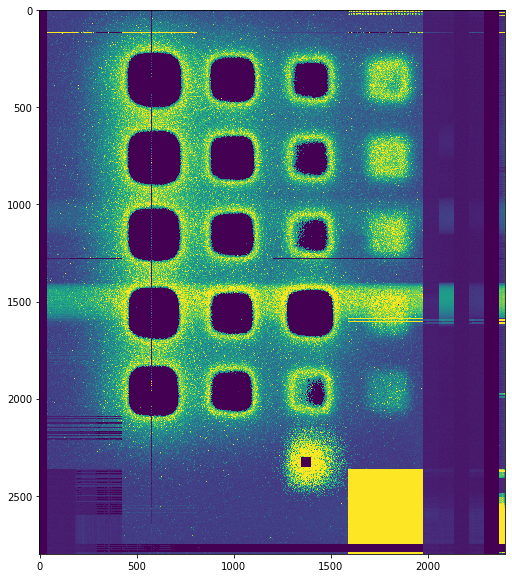

In [4]:
std[starty:endy,startx:endx]=0
plt.figure(figsize=(10,10))
plt.imshow(std,vmin=0,vmax=50)

In [5]:
chosenPixels.shape

(249900,)

(100, 51, 49)


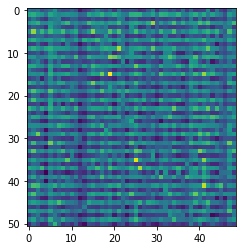

In [6]:
chosenPixels3d=chosenPixels.reshape((n_files,(endy-starty),(endx-startx)))
print(chosenPixels3d.shape)
plt.imshow(chosenPixels3d[0,:,:])

In [7]:
def bad_pix_qual(startx_fn,endx_fn,starty_fn,endy_fn,chosenPixels3d_fn):
    means_array_fn=np.zeros([endy_fn-starty_fn,endx_fn-startx_fn],dtype='float')
    stds_array_fn=np.zeros([endy_fn-starty_fn,endx_fn-startx_fn],dtype='float')
    heights_array_fn=np.zeros([endy_fn-starty_fn,endx_fn-startx_fn],dtype='float')
    
    bad_fits_counter=0
    means_fn=np.array([])
    stds_fn=np.array([])
    heights_fn=np.array([])
    x_vals_fn=np.array([])
    y_vals_fn=np.array([])

    for pix_y in range(0,(endy_fn-starty_fn)): #(endy-starty)*(endx-startx)
        for pix_x in range(0,(endx_fn-startx_fn)): #(endy-starty)*(endx-startx)
            badfit=False

            if (pix_x%30==0 and pix_y%30==0):
                print(pix_x,pix_y)
            histValues=plt.hist(chosenPixels3d_fn[:,pix_y,pix_x],bins=45)
            mphist=midpoints(histValues[1])
            meanh=chosenPixels3d_fn[:,pix_y,pix_x].mean()
            stdh=chosenPixels3d_fn[:,pix_y,pix_x].std()
            try:
                popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
            except:
                bad_fits_counter+=1
                popt=[-1,-1,-1]
                badfit=True



            heights_array_fn[pix_y,pix_x]=popt[0]
            means_array_fn[pix_y,pix_x]=popt[1]
            stds_array_fn[pix_y,pix_x]=popt[2]
#             if((pix_x==47) and (pix_y==32)):
#                 plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
#                 plt.show()
            plt.cla()
            plt.clf()
#             print(pix_x,pix_y,popt)
            # if badfit=False:        
            x_vals_fn=np.append(x_vals_fn,pix_x)
            y_vals_fn=np.append(y_vals_fn,pix_y)
            heights_fn=np.append(heights_fn,popt[0])
            means_fn=np.append(means_fn,popt[1])
            stds_fn=np.append(stds_fn,popt[2])

    print("badfits",bad_fits_counter)


    return heights_fn, means_fn, stds_fn, x_vals_fn, y_vals_fn, means_array_fn, stds_array_fn, heights_array_fn

heights, means, stds, x_vals, y_vals, means_array, stds_array, heights_array = bad_pix_qual(startx,endx,starty,endy,chosenPixels3d)

0 0
30 0


/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0 30
30 30
badfits 0


<Figure size 432x288 with 0 Axes>

even heights
[4930.99936849  232.42433574   22.99624651] 271.7044537755648 68.82910085762728
odd heights
[4807.73865617  232.67059361   22.35792034] 280.14588091457347 76.3004398834638
even means
[7995.05285432 2938.01425774   94.19296474] 2950.1043858545177 105.884816950027
odd means
[11248.55261733  3322.47631539   119.82323959] 3324.226072706283 125.313084254158
even stds
[375.49090325  10.48550531   1.66186133] 10.865190948171593 2.360364709812055
odd stds
[277.92200064  10.55301813   1.68067592] 10.976626265185853 2.3174653501573115


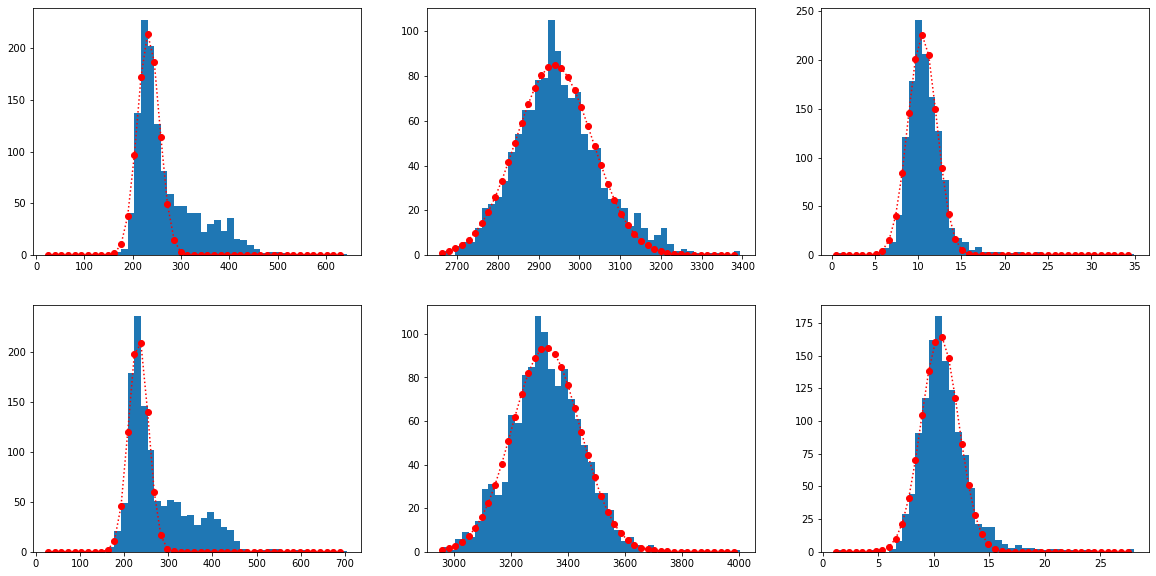

In [8]:
fig,ax=plt.subplots(2,3,figsize=(20,10))
df=pd.DataFrame({'x_vals':x_vals, 'y_vals': y_vals, 'heights':heights, 'means':means, 'stds':stds})

even_heights_mean,even_heights_std=return_param_BPM("even","heights",0)
odd_heights_mean,odd_heights_std=return_param_BPM("odd","heights",0)
even_means_mean,even_means_std=return_param_BPM("even","means",1)
odd_means_mean,odd_means_std=return_param_BPM("odd","means",1)
even_stds_mean,even_stds_std=return_param_BPM("even","stds",2)
odd_stds_mean,odd_stds_std=return_param_BPM("odd","stds",2)

In [9]:
eo_heights_means=np.zeros([endy-starty,endx-startx],dtype='float')
eo_means_means=np.zeros([endy-starty,endx-startx],dtype='float')
eo_stds_means=np.zeros([endy-starty,endx-startx],dtype='float')
eo_heights_stds=np.zeros([endy-starty,endx-startx],dtype='float')
eo_means_stds=np.zeros([endy-starty,endx-startx],dtype='float')
eo_stds_stds=np.zeros([endy-starty,endx-startx],dtype='float')

eo_heights_means[::2,:]=even_heights_mean
eo_heights_means[1::2,:]=odd_heights_mean
eo_means_means[::2,:]=even_means_mean
eo_means_means[1::2,:]=odd_means_mean
eo_stds_means[::2,:]=even_stds_mean
eo_stds_means[1::2,:]=odd_stds_mean
eo_heights_stds[::2,:]=even_heights_std
eo_heights_stds[1::2,:]=odd_heights_std
eo_means_stds[::2,:]=even_means_std
eo_means_stds[1::2,:]=odd_means_std
eo_stds_stds[::2,:]=even_stds_std
eo_stds_stds[1::2,:]=odd_stds_std

In [71]:
badpixmask=np.ones([endy-starty,endx-startx])
badpixmask[(means_array>(eo_means_means+8*eo_means_stds))]=-1
badpixmask[(stds_array>eo_stds_means+8*eo_stds_stds)]=-1
# badpixmask[(heights_array>eo_heights_means+6*eo_heights_stds)]=-1
badpixmask[(means_array<eo_means_means-8*eo_means_stds)]=-1
badpixmask[(stds_array<eo_stds_means-8*eo_stds_stds)]=-1
# means_array2[(heights_array<eo_heights_means-6*eo_heights_stds)]=-1

#ie.if mean=-1 it's a "bad pixel"

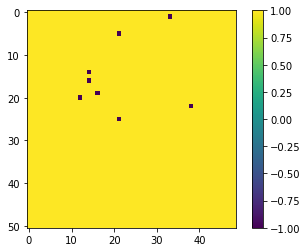

In [72]:
plt.imshow(badpixmask)
plt.colorbar()

3211.59 3186.0121382903 12.928732399915972
3 31.0 3191.1000000000004
[ 439.11340242 3186.01157508   12.92654594] smaller range
[ 439.15257461 3186.01213906   12.92872934]


Text(0, 0.5, 'ADC')

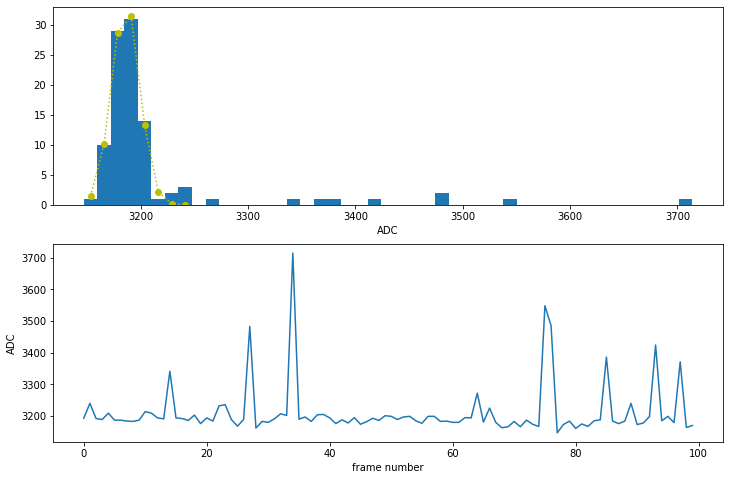

In [27]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
print(chosenPixels3d[:,41,12].mean(),means_array[41,12],stds_array[41,12])
histValues=ax[0].hist(chosenPixels3d[:,41,12],bins=45)
ax[0].set_xlabel("ADC")
mphist=midpoints(histValues[1])
print(histValues[0].argmax(),histValues[0].max(),mphist[histValues[0].argmax()])
# meanh=chosenPixels3d[:,41,12].mean()
meanh=mphist[histValues[0].argmax()]
stdh=chosenPixels3d[:,41,12].std()
popt,pcov=curve_fit(gaus,mphist[:histValues[0].argmax()+4],histValues[0][:histValues[0].argmax()+4],p0=[15,meanh,stdh])
popt2,pcov2=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
print(popt,'smaller range')
print(popt2)
_=ax[0].plot(mphist[:histValues[0].argmax()+5],gaus(mphist[:histValues[0].argmax()+5],*popt2),'yo:',label='fit')
_=ax[1].plot(chosenPixels3d[:,41,12])
ax[1].set_xlabel("frame number")

ax[1].set_ylabel("ADC")


In [14]:
reshaped_CP=np.ones([endy-starty,endx-startx])
reshaped_CP=(chosenPixels3d-means_array)/stds_array
# np.tile(badpixmask,2)
# reshaped_CP[badpixmask>0]
badpixmask3d=np.tile(badpixmask,(n_files,1))
badpixmask3d=badpixmask3d.reshape(n_files,endy-starty,endx-startx)
reshaped_CP_BPM=reshaped_CP[badpixmask3d>0]
reshaped_CP_BPM.shape

(246500,)

In [15]:
# plt.plot(chosenPixels)

1.9783735109148362 3031.636405229811 11.478396573602417 1.0
[3.39671819e+01 1.01311642e-06 9.99999906e-01]


Text(0.5, 0, 'SNR')

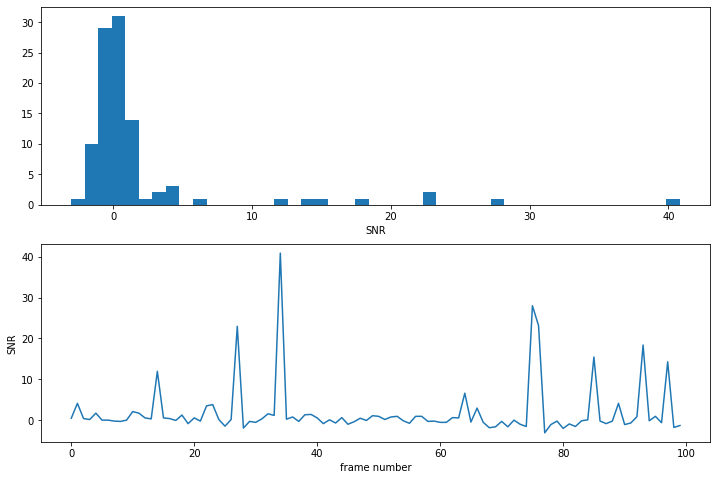

In [29]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
print(reshaped_CP[:,41,12].mean(),means_array[22,22],stds_array[22,22],badpixmask3d[0,41,12])
histValues=ax[0].hist(reshaped_CP[:,41,12],bins=45)
mphist=midpoints(histValues[1])
meanh=reshaped_CP[:,41,12].mean()
stdh=reshaped_CP[:,41,12].std()
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
print(popt)
_=ax[1].plot(reshaped_CP[:,41,12].ravel())
ax[1].set_xlabel("frame number")

ax[1].set_ylabel("SNR")
ax[0].set_xlabel("SNR")

Text(0.5, 0, 'SNR')

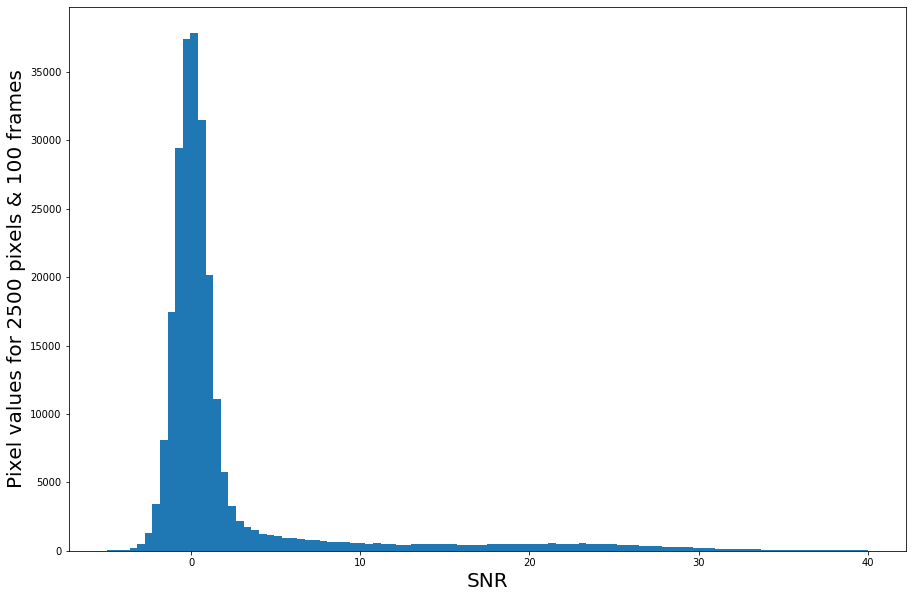

In [42]:
plt.subplots(1,1,figsize=(15,10))
_=plt.hist(reshaped_CP_BPM,bins=100,range=(-5,40))

plt.ylabel("Pixel values for 2500 pixels & 100 frames",fontsize=20)
plt.xlabel("SNR",fontsize=20)

Text(0.5, 0, 'SNR')

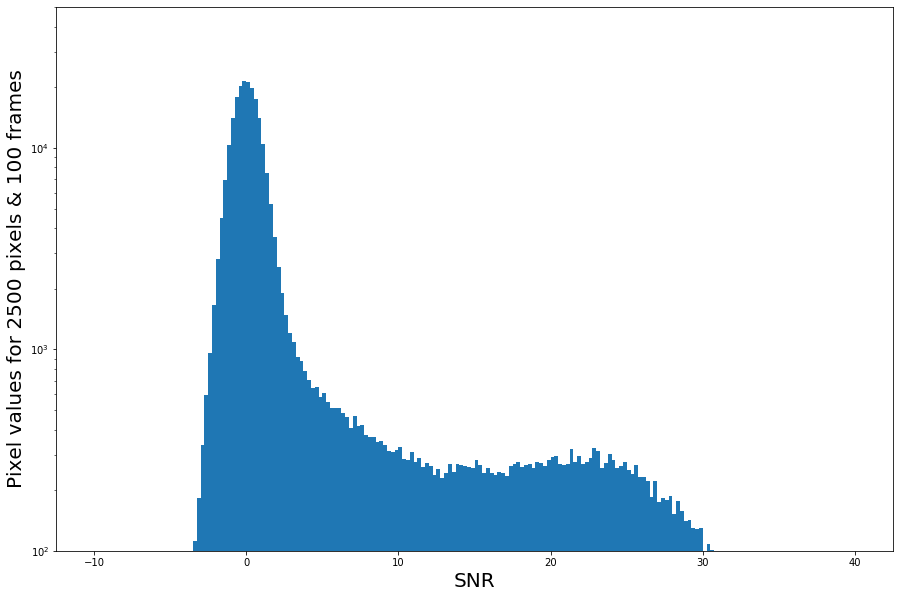

In [60]:

fig,ax=plt.subplots(1,1,figsize=(15,10))
ax.set_yscale('log')
ax.set_ylim([100,50000])

all_hist=ax.hist(reshaped_CP_BPM,bins=200,range=(-10,40))
ax.set_ylabel("Pixel values for 2500 pixels & 100 frames",fontsize=20)
ax.set_xlabel("SNR",fontsize=20)

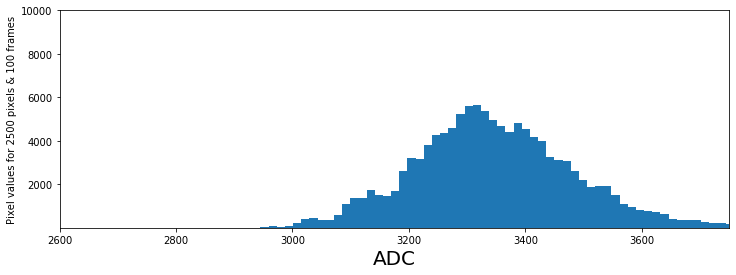

In [68]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.set_yscale('linear')
ax.set_ylim([10,10000])
ax.set_xlim([2600,3750])
ax.set_ylabel("Pixel values for 2500 pixels & 100 frames",fontsize=10)
ax.set_xlabel("ADC",fontsize=20)

all_hist=ax.hist(chosenPixels3d[:,1::2,:].ravel(),bins=100)

(41,) (41,)
[ 2.01931465e+04 -1.75714632e-02  9.14497470e-01]
[2049.09890781   22.65673684    7.48647689]


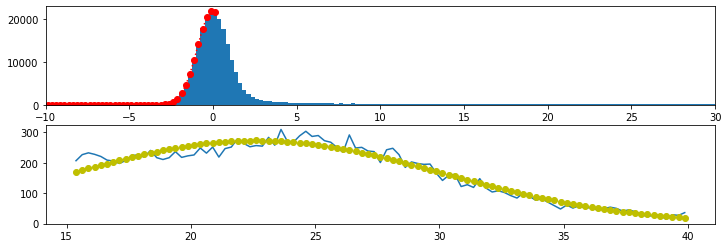

In [72]:
fig,ax=plt.subplots(2,1,figsize=(12,4))
all_hist=ax[0].hist(reshaped_CP_BPM,bins=200,range=(-10,40))

# ax.set_ylim(0,320000)
ax[0].set_xlim(-10,30)
mphist=midpoints(all_hist[1])
print(mphist[:41].shape,all_hist[0][:41].shape)
popt,pcov=curve_fit(gaus,mphist[:41],all_hist[0][:41],p0=[100000,0,1])
_=ax[0].plot(mphist[:41],gaus(mphist[:41],*popt),'ro:',label='fit')
print(popt)

popt2,pcov2=curve_fit(gaus,mphist[101:],all_hist[0][101:],p0=[60,25,1])
print(popt2) 

ax[1].plot(mphist[101:],all_hist[0][101:])
_=ax[1].plot(mphist[101:],gaus(mphist[101:],*popt2),'yo:',label='fit')

[3469.06408789   20.65487754    7.04731864]


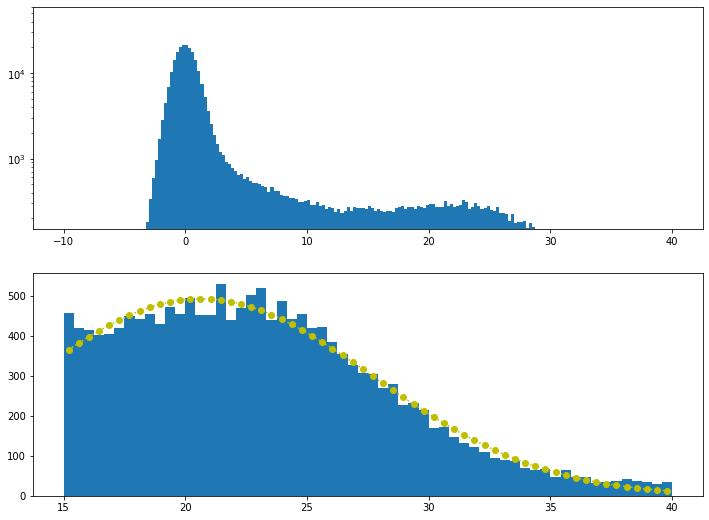

In [73]:
fig,ax=plt.subplots(2,1,figsize=(12,9))
ax[0].set_yscale('log')
ax[0].set_ylim([150.0,60000])
# ax[0].set_xlim([-5,10])

all_hist=ax[0].hist(reshaped_CP_BPM,bins=200,range=(-10,40))
mphist=midpoints(all_hist[1])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
# _=ax[0].plot(mphist[80:],gaus(mphist[80:],*popt2),'yo:',label='fit')


sub_hist=ax[1].hist(reshaped_CP_BPM,bins=60,range=(15,40))
sub_mphist=midpoints(sub_hist[1])
# _=ax[1].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
# _=ax[1].plot(mphist[20:],gaus(mphist[20:],*popt2),'yo:',label='fit')
popt3,pcov3=curve_fit(gaus,sub_mphist,sub_hist[0],p0=[60,25,1])
print(popt3) 
_=ax[1].plot(sub_mphist,gaus(sub_mphist,*popt3),'yo:',label='fit')

1361.0


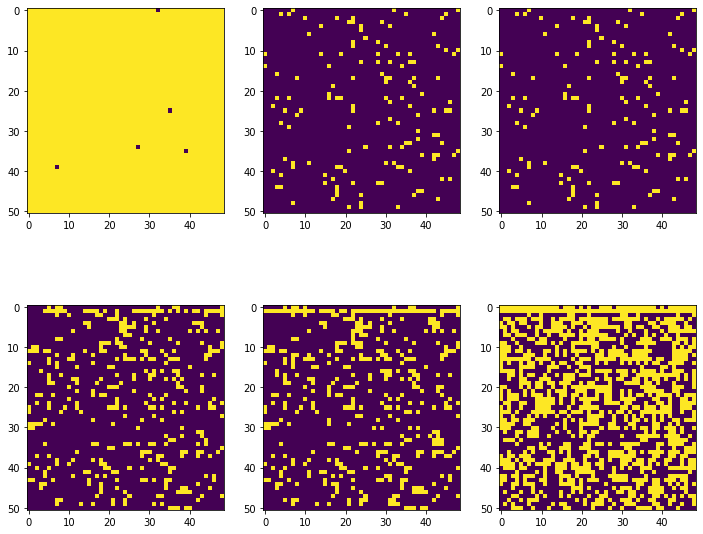

In [62]:
fig3,ax3=plt.subplots(2,3,figsize=(12,10))
sig10arr=(reshaped_CP[3,:,:]>20)
sig10arr=sig10arr.reshape(endy-starty,endx-startx)
sig5arr=(reshaped_CP[3,:,:]>10)
sig5arr=sig5arr.reshape(endy-starty,endx-startx)
sig4arr=(reshaped_CP[3,:,:]>4)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
sig3arr=(reshaped_CP[3,:,:]>3)
sig3arr=sig3arr.reshape(endy-starty,endx-startx)
sig2arr=(reshaped_CP[3,:,:]>2)
sig2arr=sig2arr.reshape(endy-starty,endx-startx)
sig1arr=(reshaped_CP[3,:,:]>0)
sig1arr=sig1arr.reshape(endy-starty,endx-startx)
ax3[0,0].imshow(badpixmask)
ax3[0,1].imshow(sig10arr)
sig10arr[badpixmask==0]=0
ax3[0,2].imshow(sig10arr)
# ax3[0,0].imshow(sig10arr-badpixmask)
# ax3[0,1].imshow(sig5arr)
# ax3[0,2].imshow(sig4arr)
ax3[1,0].imshow(sig3arr)
ax3[1,1].imshow(sig2arr)
ax3[1,2].imshow(sig1arr)
print(((reshaped_CP[2,:,:]>0)*1.0).sum())

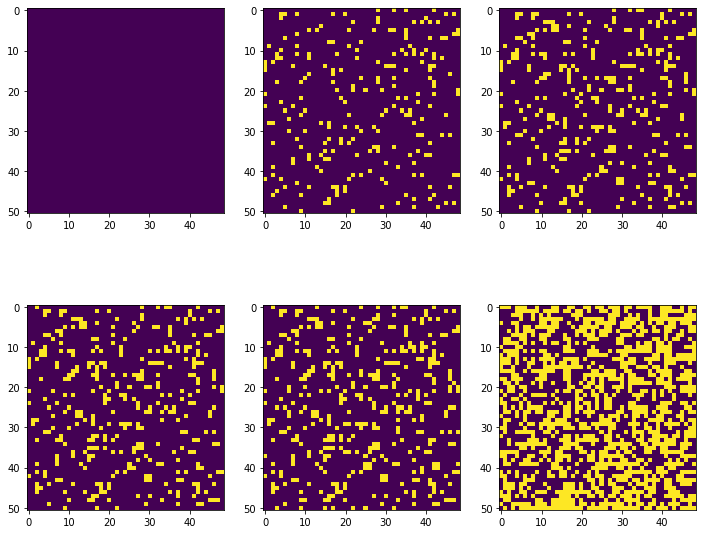

In [79]:
fig3,ax3=plt.subplots(2,3,figsize=(12,10))
sig10arr=(reshaped_CP[10,:,:]>500)
sig10arr=sig10arr.reshape(endy-starty,endx-startx)
sig5arr=(reshaped_CP[10,:,:]>10)
sig5arr=sig5arr.reshape(endy-starty,endx-startx)
sig4arr=(reshaped_CP[10,:,:]>4)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
sig3arr=(reshaped_CP[10,:,:]>3)
sig3arr=sig3arr.reshape(endy-starty,endx-startx)
sig2arr=(reshaped_CP[10,:,:]>2)
sig2arr=sig2arr.reshape(endy-starty,endx-startx)
sig1arr=(reshaped_CP[10,:,:]>0)
sig1arr=sig1arr.reshape(endy-starty,endx-startx)
ax3[0,0].imshow(sig10arr)
ax3[0,1].imshow(sig5arr)
ax3[0,2].imshow(sig4arr)
ax3[1,0].imshow(sig3arr)
ax3[1,1].imshow(sig2arr)
ax3[1,2].imshow(sig1arr)
# print(((reshaped_CP[2,:,:]>0)*1.0).sum()/9999.0)

In [80]:
for i in range (40,51,1):
    print (i)

40
41
42
43
44
45
46
47
48
49
50


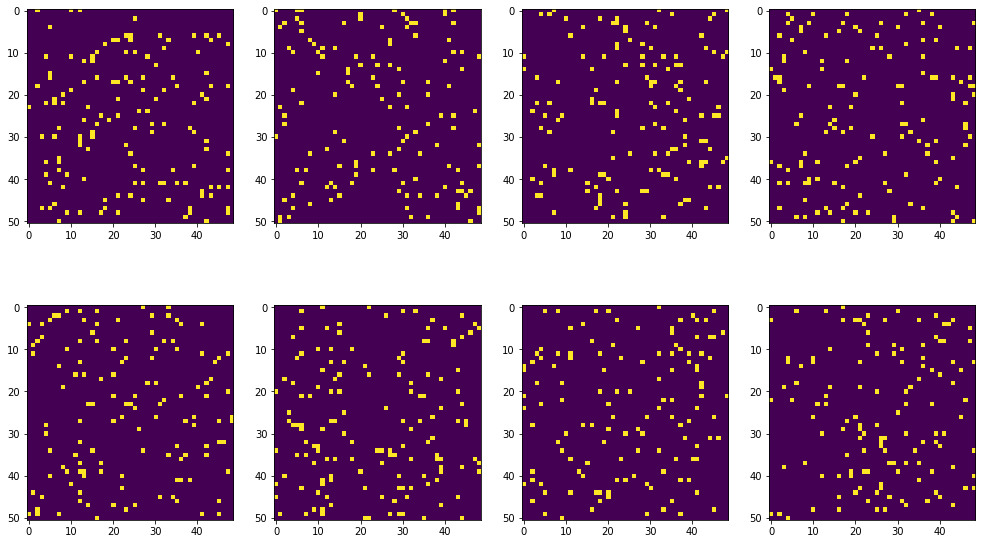

In [47]:
fig3,ax3=plt.subplots(2,4,figsize=(17,10))
sig9arr=(reshaped_CP[20,:,:]>20)
sig9arr=sig9arr.reshape(endy-starty,endx-startx)
sig10arr=(reshaped_CP[1,:,:]>20)
sig10arr=sig10arr.reshape(endy-starty,endx-startx)
sig5arr=(reshaped_CP[2,:,:]>20)
sig5arr=sig5arr.reshape(endy-starty,endx-startx)
sig4arr=(reshaped_CP[3,:,:]>20)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
sig3arr=(reshaped_CP[4,:,:]>20)
sig3arr=sig3arr.reshape(endy-starty,endx-startx)
sig2arr=(reshaped_CP[5,:,:]>20)
sig2arr=sig2arr.reshape(endy-starty,endx-startx)
sig1arr=(reshaped_CP[10,:,:]>20)
sig1arr=sig1arr.reshape(endy-starty,endx-startx)
sig7arr=(reshaped_CP[11,:,:]>20)
sig7arr=sig7arr.reshape(endy-starty,endx-startx)
ax3[0,0].imshow(sig10arr)
ax3[0,1].imshow(sig5arr)
ax3[0,2].imshow(sig4arr)
ax3[0,3].imshow(sig9arr)
ax3[1,0].imshow(sig3arr)
ax3[1,1].imshow(sig2arr)
ax3[1,2].imshow(sig1arr)
ax3[1,3].imshow(sig7arr)

In [83]:
reshaped_CP3d=(chosenPixels3d-reshaped_means)/reshaped_stds
fig,ax=plt.subplots(1,2,figsize=(12,5))
histValues=ax[0].hist(reshaped_CP3d[:,100,97],histtype='step',bins=45)
ax[0].set_xlim(-5,10)
mphist=midpoints(histValues[1])
ax[1].hist(chosenPixels3d[:,100,97],color='r',histtype='step',bins=45)
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[10,0,1])
ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
print(popt)


NameError: name 'reshaped_means' is not defined

In [ ]:
#remove bad values

all_CP_data=np.array([])
bad_fits_counter=0
outside_range_counter=0


for pix_x in range(0,(endx-startx)): #(endy-starty)*(endx-startx)
    for pix_y in range(0,(endy-starty)): #(endy-starty)*(endx-startx)
        if (pix_x%10==0 and pix_y%10==0):
            print(pix_x,pix_y)
        histValues=plt.hist(chosenPixels3d[:,pix_y,pix_x],bins=45)
        meanh=chosenPixels3d[:,pix_y,pix_x].mean()
        mphist=midpoints(histValues[1])
        try:
            popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,15])
        except:
            bad_fits_counter+=1
            continue


        plt.cla()
        plt.clf()
        
        if (pix_y%2==0):
            if(popt[1]>even_means_mean+(3*even_means_std) or popt[1]<even_means_mean-(3*even_means_std)):
                outside_range_counter+=1
#                 print(popt,even_means_mean,even_means_std)
                continue
            elif(popt[0]>even_heights_mean+(3*even_heights_std) or popt[0]<even_heights_mean-(3*even_heights_std)):
                outside_range_counter+=1
#                 print('height',popt,even_heights_mean,even_heights_std)
                continue
            elif(popt[2]>even_stds_mean+(3*even_stds_std) or popt[2]<even_stds_mean-(3*even_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                continue
        if (pix_y%2==1):
            if(popt[1]>odd_means_mean+(3*odd_means_std) or popt[1]<odd_means_mean-(3*odd_means_std)):
                outside_range_counter+=1
#                 print(popt)
                continue
            elif(popt[0]>odd_heights_mean+(3*odd_heights_std) or popt[0]<odd_heights_mean-(3*odd_heights_std)):
                outside_range_counter+=1
                continue
#                 print(popt)
            elif(popt[2]>odd_stds_mean+(3*odd_stds_std) or popt[2]<odd_stds_mean-(3*odd_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                continue

        reshaped_CP=(chosenPixels3d[:,pix_y,pix_x]-popt[1])/popt[2]
        all_CP_data=np.append(all_CP_data,reshaped_CP)

print("BF",bad_fits_counter,"OR",outside_range_counter)


In [35]:
df

,x_vals,y_vals,heights,means,stds
0,0.0,0.0,303.953090,3511.044119,14.648478
1,1.0,0.0,265.030313,3294.701434,15.491396
2,2.0,0.0,238.927337,3121.168040,12.439564
3,3.0,0.0,275.167061,3158.991478,12.624624
4,4.0,0.0,273.700642,3362.182561,15.793551
...,...,...,...,...,...
9994,94.0,100.0,245.335058,3168.938933,12.233520
9995,95.0,100.0,250.916793,3077.776770,10.580324
9996,96.0,100.0,332.185533,3017.709805,12.812120
9997,97.0,100.0,239.601756,3040.965386,13.465704


In [ ]:
df[(df['y_vals']%2==0)]

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(9,4))
_=ax[0].hist(df['heights'],bins=100,range=(0,1000))
_=ax[1].hist(df['means'],bins=100)
_=ax[2].hist(df['stds'],bins=100)

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(20,10))
_=ax[0,0].hist(df[(df['y_vals']%2==0)&(df['heights']<1000)]['heights'],bins=100)
_=ax[0,1].hist(df[(df['y_vals']%2==0)&(df['heights']<1000)]['means'],bins=100,range=(2500,4200))
_=ax[0,2].hist(df[(df['y_vals']%2==0)&(df['heights']<1000)]['stds'],bins=100)
_=ax[1,0].hist(df[(df['y_vals']%2==1)&(df['heights']<1000)]['heights'],color='r',bins=100)
_=ax[1,1].hist(df[(df['y_vals']%2==1)&(df['heights']<1000)]['means'],color='r',bins=100,range=(2500,4200))
_=ax[1,2].hist(df[(df['y_vals']%2==1)&(df['heights']<1000)]['stds'],color='r',bins=100)

In [ ]:
even_means_mean=df[(df['y_vals']%2==0)&(df['heights']<1000)]['means'].mean()
odd_means_mean=df[(df['y_vals']%2==1)&(df['heights']<1000)]['means'].mean()
even_means_std=df[(df['y_vals']%2==0)&(df['heights']<1000)]['means'].std()
odd_means_std=df[(df['y_vals']%2==1)&(df['heights']<1000)]['means'].std()
even_heights_mean=df[(df['y_vals']%2==0)&(df['heights']<1000)]['heights'].mean()
odd_heights_mean=df[(df['y_vals']%2==1)&(df['heights']<1000)]['heights'].mean()
even_heights_std=df[(df['y_vals']%2==0)&(df['heights']<1000)]['heights'].std()
odd_heights_std=df[(df['y_vals']%2==1)&(df['heights']<1000)]['heights'].std()
even_stds_mean=df[(df['y_vals']%2==0)&(df['heights']<1000)]['stds'].mean()
odd_stds_mean=df[(df['y_vals']%2==1)&(df['heights']<1000)]['stds'].mean()
even_stds_std=df[(df['y_vals']%2==0)&(df['heights']<1000)]['stds'].std()
odd_stds_std=df[(df['y_vals']%2==1)&(df['heights']<1000)]['stds'].std()
print(even_means_mean,odd_means_mean)
print(even_means_std,odd_means_std)
print(even_heights_mean,odd_heights_mean)
print(even_heights_std,odd_heights_std)
print(even_stds_mean,odd_stds_mean)
print(even_stds_std,odd_stds_std)


In [ ]:
# chosenPixels=chosenPixels.reshape((n_files,(endy-starty)*(endx-startx)))
# chosenPixels.shape
df

In [ ]:
print(means)
means2=means.reshape((endy-starty),(endx-startx))
stds2=stds.reshape((endy-starty),(endx-startx))
fig,ax=plt.subplots(2,1)
chosenPixels3d2=(chosenPixels3d-means2)/stds2
histValues=ax[0].hist(chosenPixels3d2[:,100,97],bins=45)
mphist=midpoints(histValues[1])
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,0,1])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
print(popt)
# data_mean=popt[1]
# data_std=popt[2]
# reshaped_CP=(chosenPix-data_mean)/data_std

# dtr=ax[1].hist(reshaped_CP,bins=45)
# print(chosenPixels3d[:,0,0])
# print(chosenPixels3d[:,0,0].mean())
# print(chosenPix)
chosenPixels3d2[:,100,97]>4

In [ ]:
all_CP_data=np.array([])
fig,ax=plt.subplots(2,1)

histValues=ax[0].hist(chosenPix,bins=45)
histValues[1][:-1].shape
mphist=midpoints(histValues[1])
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,3300,15])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')

data_mean=popt[1]
data_std=popt[2]
reshaped_CP=(chosenPix-data_mean)/data_std

dtr=ax[1].hist(reshaped_CP,bins=45)

In [ ]:
popt

In [ ]:
#replace bad values
all_CP_data=np.array([])
bad_fits_counter=0
outside_range_counter=0


for pix_x in range(0,(endx-startx)): #(endy-starty)*(endx-startx)
    for pix_y in range(0,(endy-starty)): #(endy-starty)*(endx-startx)
        if (pix_x%10==0 and pix_y%10==0):
            print(pix_x,pix_y)
        histValues=plt.hist(chosenPixels3d[:,pix_y,pix_x],bins=45)
        meanh=chosenPixels3d[:,pix_y,pix_x].mean()
        mphist=midpoints(histValues[1])
        try:
            popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,15])
        except:
            bad_fits_counter+=1
            continue


        plt.cla()
        plt.clf()
        
        if (pix_y%2==0):
            if(popt[1]>even_means_mean+(3*even_means_std) or popt[1]<even_means_mean-(3*even_means_std)):
                outside_range_counter+=1
#                 print(popt,even_means_mean,even_means_std)
                popt[1]=-999
                popt[2]=-999
            elif(popt[0]>even_heights_mean+(3*even_heights_std) or popt[0]<even_heights_mean-(3*even_heights_std)):
                outside_range_counter+=1
#                 print('height',popt,even_heights_mean,even_heights_std)
                popt[1]=-999
                popt[2]=-999
            elif(popt[2]>even_stds_mean+(3*even_stds_std) or popt[2]<even_stds_mean-(2*even_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                popt[1]=-999
                popt[2]=-999
        if (pix_y%2==1):
            if(popt[1]>odd_means_mean+(3*odd_means_std) or popt[1]<odd_means_mean-(3*odd_means_std)):
                outside_range_counter+=1
#                 print(popt)
                popt[1]=-999
                popt[2]=-999
            elif(popt[0]>odd_heights_mean+(3*odd_heights_std) or popt[0]<odd_heights_mean-(3*odd_heights_std)):
                popt[1]=-999
                popt[2]=-999
                outside_range_counter+=1
#                 print(popt)
            elif(popt[2]>odd_stds_mean+(3*odd_stds_std) or popt[2]<odd_stds_mean-(3*odd_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                popt[1]=-999
                popt[2]=-999

        reshaped_CP=(chosenPixels3d[:,pix_y,pix_x]-popt[1])/popt[2]
        all_CP_data=np.append(all_CP_data,reshaped_CP)

print("BF",bad_fits_counter,"OR",outside_range_counter)

In [ ]:
plt.imshow(reshaped_CP3d[1,:,:],vmin=0,vmax=10)
plt.colorbar()

In [ ]:
plt.imshow(reshaped_CP3d[2,:,:],vmin=0,vmax=10)
plt.colorbar()

In [ ]:
plt.imshow(reshaped_CP3d[3,:,:],vmin=0,vmax=10)
plt.colorbar()

In [ ]:
#ART
plt.subplots(1,1,figsize=(10,8))
sig4arr=(reshaped_CP3d[0,:,:]>4)
plt.plot(reshaped_CP3d[0,:,:])
print(sig4arr)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
plt.imshow(sig4arr)

In [ ]:
fig4,ax4=plt.subplots(1,2,figsize=(10,5))
ax4[0].plot(reshaped_CP3d[:,10,10])
histValues=ax4[1].hist(reshaped_CP3d[:,10,10],bins=45)
popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[10,0,1])
ax[1].plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
print(popt)


In [ ]:
all_CP_data

fig,ax=plt.subplots(2,1,figsize=(12,4))

all_hist=ax[0].hist(all_CP_data,bins=500,range=(-5,35))
# ax.set_ylim(0,320000)
ax[0].set_xlim(-5,30)
mphist=midpoints(all_hist[1])
popt,pcov=curve_fit(gaus,mphist,all_hist[0],p0=[100000,0,1])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')

popt2,pcov2=curve_fit(gaus,mphist[250:],all_hist[0][250:],p0=[60,25,1])
print(popt2) 

ax[1].plot(mphist[250:],all_hist[0][250:])
_=ax[1].plot(mphist[250:],gaus(mphist[250:],*popt2),'yo:',label='fit')


fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.set_yscale('log')
ax.set_ylim([200.0,30000])

all_hist=ax.hist(all_CP_data,bins=500,range=(-5,35))
mphist=midpoints(all_hist[1])
_=ax.plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
_=ax.plot(mphist[250:],gaus(mphist[250:],*popt2),'yo:',label='fit')

In [ ]:
all_CP_data[all_CP_data>4].shape

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.set_yscale('log')
ax.set_ylim([0.1,10000])

all_hist=ax.hist(all_CP_data,bins=150)
# _=ax.plot(all_hist[1][:-1],gaus(all_hist[1][:-1],*popt),'ro:',label='fit')

In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0
for pix in range((endy-starty)*(endx-startx)):
# if pix%200==0:
    print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
    plt.clf()

    histValues=plt.hist(chosenPixels[:,pix],bins=45)
    meanh=chosenPixels[:,pix].mean()
    try:
        popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[15,meanh,15])
    except:
        bad_fits_counter+=1
        continue
    print(popt)
    plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
    plt.show()
#     plt.cla()
    reshaped_CP=(chosenPixels[:,pix]-popt[1])/popt[2]
    all_CP_data=np.append(all_CP_data,reshaped_CP)
print(bad_fits_counter)

In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0

for pix in range(0,10): #(endy-starty)*(endx-startx)
    if pix%200==0:
        print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
#     histValues=plt.hist(chosenPixels[:,pix],bins=45)
#     meanh=chosenPixels[:,pix].mean()
    try:
        popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[15,meanh,15])
    except:
        bad_fits_counter+=1

        continue
#     print(popt)
#     plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
#     plt.show()
    plt.cla()
    plt.clf()
    reshaped_CP=(chosenPixels[:,pix]-popt[1])/popt[2]
    all_CP_data=np.append(all_CP_data,reshaped_CP)

print(bad_fits_counter)


In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0

for pix in range(0,10): #(endy-starty)*(endx-startx)
    if pix%200==0:
        print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
#     histValues=plt.hist(chosenPixels[:,pix],bins=45)
#     meanh=chosenPixels[:,pix].mean()
    histValues=plt.hist(chosenPixels[:,pix],bins=45)
    mu,sig=norm.fit((chosenPixels[:,pix]))
    print(mu,sig)
    plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],15, mu, sig),'ro:',label='fit')
    plt.show()
    plt.clf()


In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0
for pix in range(348,351): #(endy-starty)*(endx-startx)
# if pix%200==0:
    print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
    plt.clf()

    print(chosenPixels[:,pix].min()-1)
    print(chosenPixels[:,pix].max()+1)
    bins = np.linspace(chosenPixels[:,pix].min()-1,chosenPixels[:,pix].min()+45,45 )
    digitized = np.digitize(chosenPixels[:,pix], bins)
    print(bins)
    print(digitized)
    print(len(bin_means))
#     histValues=plt.hist(chosenPixels[:,pix],bins=45)
    
#     meanh=chosenPixels[:,pix].mean()
#     try:
#         popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[15,meanh,15])
#     except:
#         bad_fits_counter+=1
#         continue
#     print(popt)
#     plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
#     plt.show()
# #     plt.cla()
#     reshaped_CP=(chosenPixels[:,pix]-popt[1])/popt[2]
#     all_CP_data=np.append(all_CP_data,reshaped_CP)
# print(bad_fits_counter)


In [ ]:
np.linspace(chosenPixels[:,pix].min()-1,chosenPixels[:,pix].max()-1,45).shape

In [24]:
arrr=np.random.rand(5,5)
print(arrr,'\n\n',arrr[1::2,:])

[[0.26317239 0.93813709 0.47409645 0.55702643 0.79161294]
 [0.59689037 0.48684897 0.25682387 0.44204297 0.67585104]
 [0.36649008 0.16621356 0.05738193 0.62100128 0.71518509]
 [0.21525997 0.69791977 0.22101079 0.95403563 0.56247168]
 [0.92116944 0.57578942 0.38057115 0.21360604 0.28016015]] 

 [[0.59689037 0.48684897 0.25682387 0.44204297 0.67585104]
 [0.21525997 0.69791977 0.22101079 0.95403563 0.56247168]]


In [ ]:
number of hits/size of clusters vs radiation damage 

